# 로지스틱 회귀 함수를 사이킷런 사용 없이 구현해보기

## 구현 순서

## 1. Do it! 딥러닝 프로그래밍 로지스틱함수 뉴런 구현 (완료)

## 2. Do it! 딥러닝 프로그래밍 로지스틱함수 단일 신경망 구현 (완료)

## 3. Do it! 딥러닝 프로그래밍 로지스틱함수 사이킷런 구현 (완료)

## 4. 코세라 딥러닝 특화과정 로지스틱 함수 신경망 구현 (구현 중)

아마 실무에 투입이 된다면, 상황에 따라 텐서플로우나 파이토치와 같은 딥러닝 프레임워크를 기업에 맞게 매핑해서 사용하는 경우가 반드시 존재할 것이다.

따라서 

- 상황에 맞는 적절한 딥러닝 훈련 모델을 선택할 수 있어야하고

- 라이브러리 없이 구현해야하는 상황이 분명히 존재하기 때문에

이러한 상황에 발 맞춰 코드를 이해하는 작업을 추가하게 되었다.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

from sklearn.datasets import load_breast_cancer

## 사전 준비 : 데이터셋 로딩

사용하는 데이터 셋은 사이킷런에서 미국 위스콘신 주의 유방암 데이터이며, 타겟 데이터는 0/1로 분류되어 있다 (유방암 존재 유무)

In [2]:
cancer = load_breast_cancer() 

In [3]:
print(cancer.data.shape, cancer.target.shape)
# 암 데이터에서 569개의 샘플이 있고, 30개의 특성이 있는 것을 확인

(569, 30) (569,)


In [4]:
cancer.data[:3] # 30개의 특성을 1개의 샘플로 묶어놓은 것을 알 수 있음

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

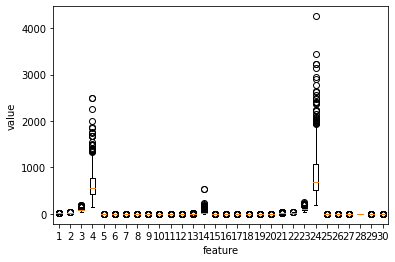

In [5]:
# 위의 데이터 시각화 해보기

plt.boxplot(cancer.data)
plt.xlabel("feature")
plt.ylabel("value")
plt.show()
# 4, 14, 24번째 특징이 두드러지는 색깔을 갖고 있음

In [6]:
# 각 특징을 확인해보니, 모두 area (즉, 넓이)
cancer.feature_names[[3,13,23]]

array(['mean area', 'area error', 'worst area'], dtype='<U23')

In [7]:
# 그러나 여기서 해결해야하는 문제는 현재 암에 걸렸는지, 암이 아닌지를 판별하는 과정임 (즉, 이진분류)
# cancer.target에는 2가지 값만 있는 것을 확인할 수 있음
np.unique(cancer.target, return_counts=True) # 암 유무를 0/1로 표현했고, 각 갯수가 몇 개씩 등장하는지 갯수까지 카운트 해줌

(array([0, 1]), array([212, 357]))

In [8]:
# 데이터 세트 저장하기
x = cancer.data
y = cancer.target

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# stratify 는 훈련 데이터를 나눌 때 클래스 비율을 동일하게 만들 수 있다.
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2, random_state=42)

In [11]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
np.unique(y_train, return_counts=True)

(455, 30) (114, 30)
(455,) (114,)


(array([0, 1]), array([170, 285]))

## 1. do it 딥러닝 입문에서 구현한 로지스틱 회귀 함수 뉴런

로지스틱 회귀 함수 자체를 구현하는 것에 어려움은 없다.

그러나 이걸 한 개의 뉴런으로 만들어서 작업해야하는 상황이라면?

In [12]:
class DoItLogisticNeuron:
    def __init__(self):
        self.w = None
        self.b = None
    
    def forward_propagation(self, x):
        z = np.sum(self.w * x) + self.b
        return z
    
    def backward_propagation(self,x, err):
        dw = x * err
        db = 1 * err
        return dw, db
    
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs = 100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        for i in range(epochs):
            for x_i, y_i in zip(x, y):
                z = self.forward_propagation(x_i)
                a = self.activation(z)
                err = - (y_i - a)
                dw, db = self.backward_propagation(x_i, err)
                self.w -= dw
                self.b -= db
    def predict(self, x):
        z = [self.forward_propagation(x_i) for x_i in x]
        a = self.activation(np.array(z))
        
        return a > 0.5

In [13]:
neuron = DoItLogisticNeuron()
neuron.fit(x_train, y_train)

In [14]:
np.mean(neuron.predict(x_test) == y_test)

0.8245614035087719

## 2. do it 딥러닝 입문에서 구현한 로지스틱 회귀 함수 단일 신경망

위에서 한 개의 뉴런을 구현한 것이었다면, 이번에는 한 층의 신경망을 구현해 이진 분류의 정확도를 높이는 방법으로 진행한다.

In [15]:
class DoItSigleLayerLogistic:
    def __init__(self):
        self.w = None
        self.b = None
        self.losses = []
    
    def forward_propagation(self, x):
        z = np.sum(self.w * x) + self.b
        return z
    
    def backward_propagation(self,x, err):
        dw = x * err
        db = 1 * err
        return dw, db
    
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs = 100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        for i in range(epochs):
            loss = 0
            idx = np.random.permutation(np.arange(len(x))) # 인덱스 셔플
            for j in idx:
                z = self.forward_propagation(x[j])
                a = self.activation(z)
                
                err = - (y[j] - a)
                dw, db = self.backward_propagation(x[j], err)
                self.w -= dw
                self.b -= db
                a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위한 클리핑 후 손실 누적 작업?
                
                loss += -(y[j] * np.log(a) + (1-y[j]) * np.log(1-a))
            self.losses.append(loss/len(y))
    def predict(self, x):
        z = [self.forward_propagation(x_i) for x_i in x]
        return np.array(z) > 0 #스텝 함수 적용?
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [16]:
layer = DoItSigleLayerLogistic()

layer.fit(x_train, y_train)
layer.score(x_test, y_test)

0.6842105263157895

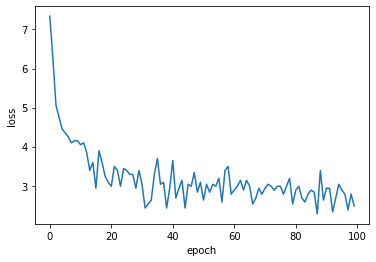

In [17]:
plt.plot(layer.losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## 3. 사이킷런으로 로지스틱 회귀 수행하기

In [18]:
from sklearn.linear_model import SGDClassifier

# tol : 지정한 값만큼 손실함수 값이 감소하지 않으면 실행 중지

sgd = SGDClassifier(loss="log", max_iter=100, tol=1e-3, random_state=42)

In [19]:
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test)

0.8333333333333334

In [20]:
sgd.predict(x_test[:10])

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

## 4. Coursera에서 구현된 로지스틱 함수 클래스 객체화 & 유방암 분류 모델에 적용해보기

In [33]:
class CourseraLogistic:
    
    def __init__(self):
        self.w = None
        self.b = None
    
    def sigmoid(self, z):
        
        s = 1 / (1 + np.exp(-z))

        return s
    
    def forward(self, x, y):
        m = x.shape[1]
        
        A = self.sigmoid(np.dot(self.w.T, x) + self.b)
        
        cost = np.multiply(-(1/m), np.sum(y * np.log(A) + (1-y) * np.log(A)))
        
        cost = np.squeeze(np.array(cost))
        
        return cost
    
    def backward(self, x, y):
        m = x.shape[1]
        
        A = self.sigmoid(np.dot(self.w.T, x) + self.b)
        
        dw = np.multiply(1/m, np.dot(x, (A-y).T))
        
        db = np.multiply(1/m, np.sum(A-y))
        
        grads = {"dw" : dw, "db" : db}
        
        return grads
    
    def optimizer(self, x, y, epochs=100, learning_rate=0.009, print_cost=True):
        
        costs = []
        
        for i in range(epochs):
            
            cost = self.forward(x,y)
            
            grads = self.backward(x,y)
            
            dw = grads["dw"]
            
            db = grads["db"]
            
            w = w - learning_rate * dw
            b = b - learning_rate * db

            # YOUR CODE ENDS HERE

            # Record the costs
            if i % 100 == 0:
                costs.append(cost)

                # Print the cost every 100 training iterations
                if print_cost:
                    print ("Cost after iteration %i: %f" %(i, cost))
    
        params = {"w": w,
                  "b": b}

        grads = {"dw": dw,
                 "db": db}

        return params, grads, costs
    
    def predict(self,x):
        
        m = x.shape[1]
        
        y_pred = np.zeros((1,m))
        
        w = w.reshape(x.shape[0], 1)
        
        A = self.sigmoid(np.dot(w.T, x) + b)
        
        for i in range(A.shape[1]):
            
            if A[0, i] > 0.5 :
                Y_prediction[0,i] = 1
            else:
                Y_prediction[0,i] = 0
        
        return y_pred
    
    def model(self, x_train, y_train, x_test, y_test, epochs=2000, learning_rate=0.5, print_cost=False):
        
        self.w = np.zeros((x_train.shape[0], 1))
        self.b = 0
        
        params, grads, costs = self.optimizer(x_train, y_train, epochs, learning_rate, print_cost)
        
        self.w = params["w"]
        self.b = params["b"]
        
        y_pred_test = predict(x_test)
        
        y_pred_train = predict(x_train)
        
        if print_cost:
            print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
            print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))


        d = {"costs": costs,
             "y_pred_test": y_pred_test, 
             "y_pred_train" : Y_pred_train, 
             "w" : w, 
             "b" : b,
             "learning_rate" : learning_rate,
             "epochs": epochs}

        return d

In [35]:
layer = CourseraLogistic()

layer.model(x_train, y_train, x_test, y_test)